In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('/global/homes/f/fnafis/KrSTC/analysis/physrev.mpl')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm
from scipy.fft import fft, ifft
from scipy import stats
import pickle

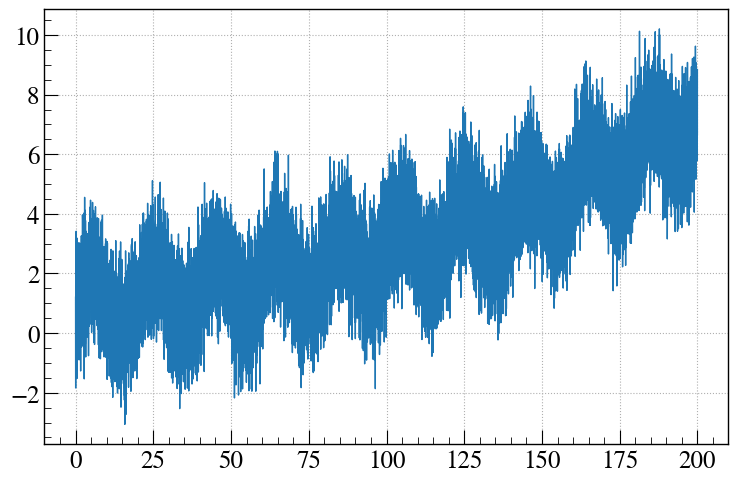

In [2]:
x = np.arange(0, 200, 0.01)
random_numbers_from_normal = np.random.normal(loc = 0, scale = 1, size = len(x))
sine = np.sin(2 * np.pi * 0.05 * x)
trend = np.exp(0.01 * x)
y = sine + random_numbers_from_normal + trend
plt.plot(x,sine+random_numbers_from_normal+trend, lw=1)

## Dickey-Fuller test of stationarity

In [3]:
import statsmodels.tsa.stattools as sts

In [5]:
sts.adfuller(trend+random_numbers_from_normal)

(-1.1018828806350518,
 0.7143204502924535,
 46,
 19953,
 {'1%': -3.4306777773505996,
  '5%': -2.86168486605018,
  '10%': -2.566847108243414},
 56999.85162387128)

p = 0.714, so the null hypothesis (i.e the time series is non-stationary) - we are 71.4% confident that we should reject that. 

# Seasonality, autocorrelation

(0.0, 100.0)

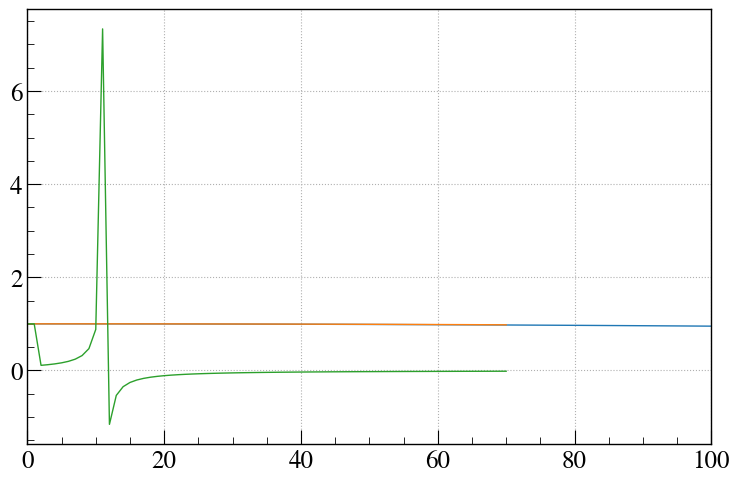

In [41]:
a = np.random.normal(size=1000)
a = sine
corrcoefs = []
corrcoefs.append(np.corrcoef(a,a)[0,1])
for i in range(1, len(a)):
    if i<len(a)/2:
        corrcoefs.append(np.corrcoef(a[:-i], a[i:])[0,1])
plt.plot(corrcoefs[1:], lw=1)
# print(corrcoefs)
acf = sm.tsa.stattools.acf(a, adjusted=True, nlags=70)
plt.plot(acf, lw=1)
pacf = sm.tsa.stattools.pacf(a, nlags=70)
plt.plot(pacf, lw=1)
plt.xlim(0,100)

10


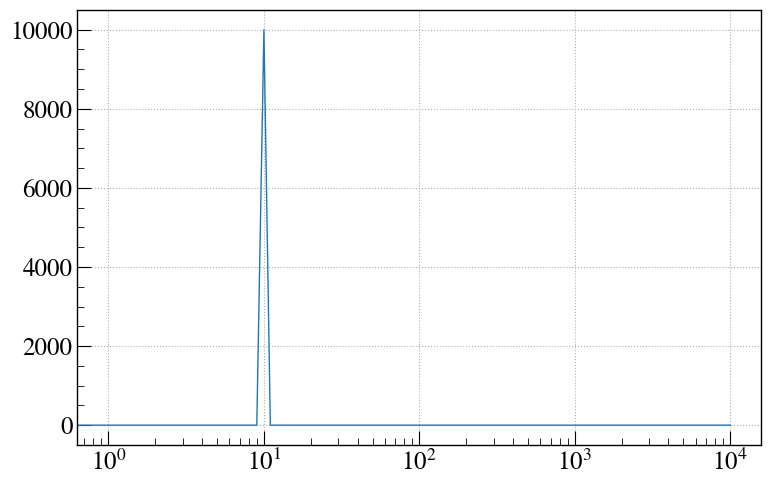

In [42]:
x = fft(sine)
x = np.abs(x[:len(x)//2])
print(np.argmax(x))
plt.plot(x, lw=1)
plt.xscale('log')

# AR

In [43]:
from statsmodels.tsa.arima.model import ARIMA

In [54]:
train_dataset = y[:int(0.8*len(y))]
test_dataset = y[int(0.8*len(y)):]
train_dataset.shape

(16000,)

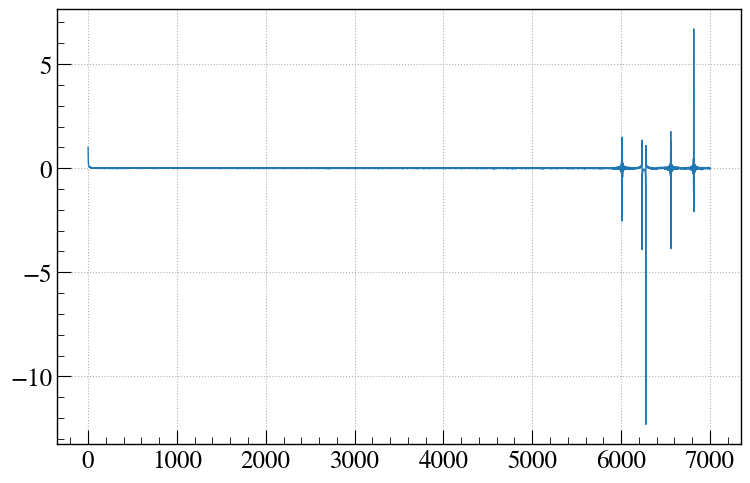

In [65]:
# pacf = sm.tsa.stattools.pacf(train_dataset, nlags=7000)
# plt.plot(pacf, lw=1)

In [55]:
# ARIMA(1,0,0) = AR(1)
model = ARIMA(train_dataset, order=(10,0,0)) # 10 is the number of lags to consider, so now the AR function is x(t) = a1*x(t-1) + a2*x(t-2) + ... + a10*x(t-10) + c + noise_term
model_fit = model.fit()

In [56]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                16000
Model:                ARIMA(10, 0, 0)   Log Likelihood              -23389.087
Date:                Sun, 19 May 2024   AIC                          46802.174
Time:                        22:29:34   BIC                          46894.338
Sample:                             0   HQIC                         46832.656
                              - 16000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4636      0.143     17.253      0.000       2.184       2.743
ar.L1          0.1092      0.008     13.943      0.000       0.094       0.124
ar.L2          0.0889      0.008     11.094      0.000       0.073       0.105
ar.L3          0.0921      0.008     11.720      0.000       0.077       0.108
ar.L4          0.0888      0.008     11.280      0.000       0.073       0.104
ar.L5          0.0975      0.008     12.363      0.000       0.082       0.113
ar.L6          0.0932      0.008     11.797      0.000       0.078       0.109
ar.L7          0.0964      0.008     12.221      0.000       0.081       0.112
ar.L8          0.0875      0.008     11.050      0.000       0.072       0.103
ar.L9          0.0942      0.008     11.835      0.000       0.079       0.110
ar.L10         0.0945      0.008     11.874      0.000       0.079       0.110
sigma2         1.0894      0.012     90.083      0.000       1.066       1.113
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 4.95
Prob(Q):                              0.30   Prob(JB):                         0.08
Heteroskedasticity (H):               1.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

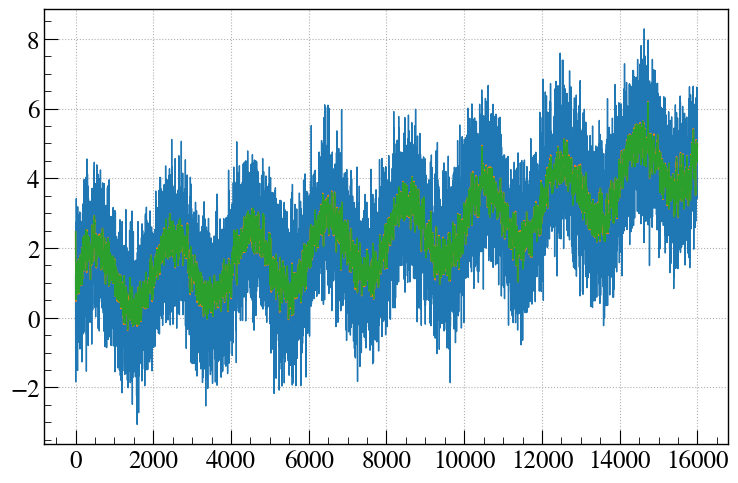

In [62]:
plt.plot(train_dataset, lw=1)
y_fit = model_fit.predict(start=0, end=len(train_dataset))
plt.plot(y_fit, lw=1)
model_fit_2 = ARIMA(y_fit, order=(10,0,0)).fit()
y_fit_2 = model_fit_2.predict(start=0, end=len(train_dataset))
plt.plot(y_fit_2, lw=1)

# LSTM

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

2024-05-19 21:15:54.194158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:15:56.099400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
train_dataset = y[:int(0.8*len(y))]
test_dataset = y[int(0.8*len(y)):]
def create_X_Y_for_LSTM(data, time_steps):
    X, Y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        Y.append(data[i+time_steps])
    return np.array(X), np.array(Y)
time_steps = 2
trainX, trainY = create_X_Y_for_LSTM(train_dataset, time_steps=time_steps)
testX, testY = create_X_Y_for_LSTM(test_dataset, time_steps=time_steps)
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
trainX

array([[1.804307  , 0.89568367],
       [0.89568367, 0.68119485],
       [0.68119485, 0.43932402],
       ...,
       [4.72810434, 3.33649208],
       [3.33649208, 4.10812246],
       [4.10812246, 3.83316589]])

In [11]:
model = Sequential()
model.add(LSTM(5, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
pickle.dump(model, open('model_basic_lstm_5_2_1.pkl', 'wb'))

Epoch 1/100


2024-05-19 21:16:34.660415: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


15998/15998 - 50s - 3ms/step - loss: 1.5514
Epoch 2/100
15998/15998 - 23s - 1ms/step - loss: 1.3623
Epoch 3/100
15998/15998 - 23s - 1ms/step - loss: 1.3587
Epoch 4/100
15998/15998 - 23s - 1ms/step - loss: 1.3568
Epoch 5/100
15998/15998 - 23s - 1ms/step - loss: 1.3567
Epoch 6/100
15998/15998 - 23s - 1ms/step - loss: 1.3548
Epoch 7/100
15998/15998 - 22s - 1ms/step - loss: 1.3566
Epoch 8/100
15998/15998 - 23s - 1ms/step - loss: 1.3570
Epoch 9/100
15998/15998 - 22s - 1ms/step - loss: 1.3538
Epoch 10/100
15998/15998 - 23s - 1ms/step - loss: 1.3538
Epoch 11/100
15998/15998 - 23s - 1ms/step - loss: 1.3539
Epoch 12/100
15998/15998 - 22s - 1ms/step - loss: 1.3556
Epoch 13/100
15998/15998 - 22s - 1ms/step - loss: 1.3556
Epoch 14/100
15998/15998 - 22s - 1ms/step - loss: 1.3528
Epoch 15/100
15998/15998 - 23s - 1ms/step - loss: 1.3543
Epoch 16/100
15998/15998 - 23s - 1ms/step - loss: 1.3532
Epoch 17/100
15998/15998 - 22s - 1ms/step - loss: 1.3538
Epoch 18/100
15998/15998 - 23s - 1ms/step - loss: 1.